In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

#calculates requested man power from a project (t_start, dur, m) which curently has progress p at time t.

def request(t, t_start, dur, p, c, m):
    
    if t >= t_start and p < 1 and p >=0:       
        if t >= dur + t_start:
            return c*m
        else:
            return m*min(c, (1-p)/(1-(t-t_start)/dur))
    else: 
        return 0

#calculates given manpower with requests r.
    
def given_tanh(r, beta, manage_sigma, dur, priority):

    if np.sum(r) > 0:
        if priority == 0:
            w = r/np.sum(r)
        elif priority >0:
            w = r*dur/np.sum(r*dur)
        elif priority <0:
            w = r/dur/np.sum(r/dur)
        g = beta*np.tanh(np.sum(r)/beta) * w + np.random.normal(0, manage_sigma)
        return g*(r>0)
    else: 
        return np.zeros([len(r)])
    
#returns progress and efficiency
    
def progress_update(g, t0, m, eff_prev, eff_sigma):
    u = 1.15* abs(np.random.normal(0, eff_sigma))
    eff = (2*eff_prev + np.exp(-u))/3
    #eff = np.exp(u)*1.15
    return [eff*g/m/t0, eff]

#Cost function, not currently used.

def cost_update(g, r, alpha, c0):
    return (np.exp(alpha * r) + c0)*g

In [2]:
#System variables:-

alpha = 10           #cost modifier
T = 5*365            #number of time steps in simulation IF YOU CHANGE, UPDATE DISTRUBUTIONS OF PROJECTS!!!!
c = 1.5              #cap on requested manpower as a proposition to scheduled output
init_eff = 0.8       #Initial efficiency
beta = 150           #competition variable and max work output (high values = low competition, low values = High competition)
manage_sigma = 0.1   #given manpower randomness controller (varience of normal distribution)
eff_sigma = 0.1      #efficience randomness controller

In [3]:
#Input  - schedule of projects to be ran and what projects to prioritise (1 long, 0 none, -1 short) and what return_type you want
#Output - Either sum of requestes manpower ~ costs or all the simulation data depending on return_type.
#Runs the model

def model(schedule,priority,return_type):
    start = schedule[:,0]
    m = schedule[:,1]
    dur = schedule[:,2]
    n = len(start)
    
    # dynamic data
    r = np.zeros([n,2*T])
    efficiency = np.ones([n, 2*T])*init_eff
    progress = np.zeros([n, 2*T])
    given_mp = np.zeros([n,2*T])
    cum_prog = np.zeros([n,2*T])
    actual_dur = [0]*n
    
    for t in range(2*T-1):
        for proj in range(n):
            if cum_prog[proj][t] < 1:
                r[proj][t] = request(t , start[proj], dur[proj], cum_prog[proj][t], c, m[proj])

        given_mp[:,t] = given_tanh(r[:,t], beta, manage_sigma, dur, priority)

        for proj in range(n):
            if cum_prog[proj][t] < 1 and t >= start[proj]:
                progress[proj][t+1], efficiency[proj][t+1] = progress_update(given_mp[proj,t], dur[proj], m[proj], efficiency[proj][t], eff_sigma)
                cum_prog[proj][t+1] = cum_prog[proj][t] + progress[proj][t+1]
                if cum_prog[proj][t+1] >= 1:
                    cum_prog[proj][t+1] = 1
                    actual_dur[proj] = t + 1 - start[proj] 
            else:
                progress[proj][t+1] = 0
                cum_prog[proj][t+1] = cum_prog[proj][t]
    
             
    if return_type == 'cost':
        return np.sum(r)
    elif return_type == 'full':
        return [r, efficiency, given_mp, cum_prog]
    elif return_type == 'variable_test':
        avg_over_dur = 0
        exp_cost = 0
        avg_over_cost = 0
        for proj in range(n):
            avg_over_dur += actual_dur[proj]/dur[proj]
            exp_cost += m[proj]*dur[proj]
            avg_over_cost += np.sum(r[proj])/(m[proj]*dur[proj])
        return [avg_over_dur/n, np.sum(r)/exp_cost, avg_over_cost/n]
    else:
        return np.sum(r)

#runs the model on a set of projects k times with priority, returns average, min and max results or all the data.

def run(projects,k,priority,return_type):
    data = []
    for i in range(k):
        data.append(model(projects,priority,return_type))
    if return_type == 'cost':
        return [np.average(data), np.max(data), np.min(data)]
    elif return_type == 'full':
        return data
    elif return_type == 'variable_test':
        return np.average(data,axis=0)
    else:
        return [np.average(data), np.max(data), np.min(data)]

In [4]:
#Creats a list of projects with length and work load WITHOUT start times - we call this proto projects.

def proto_projlist(num_proj):
    W = []
    for i in range(num_proj):
        W.append([max(0.0001,int(np.random.lognormal(mean=2.12,sigma=1.03))), max(1,min(T-1,int(np.random.lognormal(mean=6.18,sigma=0.722))))])
    return W

#Takes a list of proto projects and distrubutes them acording to the data we where given.

def real_projlist(proto_proj):
    W = []
    for proj in proto_proj:
        W.append([max(0,int(np.random.normal(loc=709,scale=350))), proj[0], proj[1]])
    return np.asarray(W)

#Takes a list of proto projects and distrubutes them evenly with spacing space.

def spaced_projlist(space, proto_proj):
    W = []
    time = np.linspace(0,space,len(proto_proj))
    for i in range(len(proto_proj)):
        W.append([int(time[i]), proto_proj[i][0],proto_proj[i][1]])
    return np.asarray(W)

#Takes a list of proto projects and distrubutes them uniformly randomly so they are expected to finish by the end of T.

def rand_projlist(proto_proj):
    W = []
    for proj in proto_proj:
        W.append([np.random.randint(low=0,high=(T-proj[1])), proj[0], proj[1]])
    return np.asarray(W)

In [5]:
#Generates a set of projects.

proto = proto_projlist(20)

#Define how many runs at each value to have, how many c, beta and eff values to try

run_number = 20
c_vals = 5
beta_vals = 6
eff_vals = 11

change_var_data_dur = np.zeros([c_vals,beta_vals,eff_vals])
change_var_data_tcot = np.zeros([c_vals,beta_vals,eff_vals])
change_var_data_pcot = np.zeros([c_vals,beta_vals,eff_vals])

#Runs the model with differing values of c, beta and eff_sigma

for i in range(c_vals):
    c = 1 + i*0.5
    for j in range(beta_vals):
        beta = 150 + j*20
        for k in range(eff_vals):
            eff_sigma = k*0.1
            temp = run(real_projlist(proto),run_number,0, 'variable_test')
            change_var_data_dur[i][j][k] = temp[0]
            change_var_data_tcot[i][j][k] = temp[1]
            change_var_data_pcot[i][j][k] = temp[2]


In [6]:
#Calculates the difference of the data provided by heathrow against the run data.

change_var_data_dur_alt = np.zeros([c_vals,beta_vals,eff_vals])
change_var_data_tcot_alt = np.zeros([c_vals,beta_vals,eff_vals])
change_var_data_pcot_alt = np.zeros([c_vals,beta_vals,eff_vals])
comb_dif = np.zeros([c_vals,beta_vals,eff_vals])

for i in range(c_vals):
    for j in range(beta_vals):
        for k in range(eff_vals):
            change_var_data_dur_alt[i][j][k] = abs(change_var_data_dur[i][j][k]-1.3)
            change_var_data_tcot_alt[i][j][k] = abs(change_var_data_tcot[i][j][k]-1.7)
            change_var_data_pcot_alt[i][j][k] = abs(change_var_data_pcot[i][j][k]-3.1)
            comb_dif[i][j][k] = (change_var_data_dur_alt[i][j][k]**2 + change_var_data_tcot_alt[i][j][k]**2)**0.5

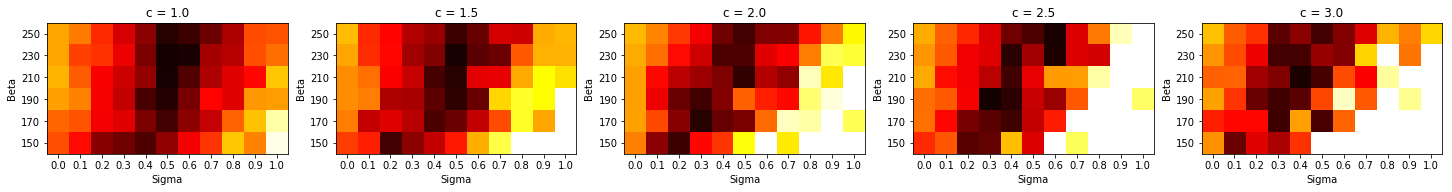

In [7]:
#Outputs heat map of differences between model data and real data to determine best fitting values.

y_axis = [150 + 20*x for x in range(beta_vals)]
x_axis = [x/10 for x in range(eff_vals)]

fig, ax = plt.subplots(ncols = c_vals,figsize=(25, 15))


for i in range(c_vals):
    im = ax[i].imshow(change_var_data_tcot_alt[i], cmap='hot', origin = 'lower', vmin = 0, vmax = 1)
    
    ax[i].set_xticks(np.arange(len(x_axis)))
    ax[i].set_yticks(np.arange(len(y_axis)))

    ax[i].set_xticklabels(x_axis)
    ax[i].set_yticklabels(y_axis)
    ax[i].set_ylabel("Beta")
    ax[i].set_xlabel("Sigma")
    ax[i].set_title("c = " + str(1 + i*0.5))


plt.savefig("cost_heatmap.png")